In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!nvidia-smi

Mon Jan 13 21:29:02 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import zipfile
!unzip '/content/drive/MyDrive/emotions.zip'

Archive:  /content/drive/MyDrive/emotions.zip
replace fer2013.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace fer2013/fer2013.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [5]:
import pandas as pd

df = pd.read_csv('fer2013/fer2013.csv')
df

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [6]:
df['Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [7]:
import numpy as np
import math


def str2img(x):
  data = np.array([int(val) for val in x.split()])
  dimention = int(math.sqrt(len(data)))
  data = data.reshape(dimention, dimention)
  return data


y_train = df.loc[df['Usage'] == 'Training', 'pixels']
y_train = np.stack(y_train.apply(str2img), axis=0)

y_valid = df.loc[df['Usage'] == 'PrivateTest', 'pixels']
y_valid = np.stack(y_valid.apply(str2img), axis=0)

y_test = df.loc[df['Usage'] == 'PublicTest', 'pixels']
y_test = np.stack(y_test.apply(str2img), axis=0)

y_train.shape, y_valid.shape, y_test.shape

((28709, 48, 48), (3589, 48, 48), (3589, 48, 48))

At first, we define x_train, x_valid and x_test as the main images, Next we apply a noise like poisson noise on those images on x_train, x_valid and x_test data.

In [8]:
import cv2 as cv
mean=0
sigma=10

def add_poisson_noise(img):
    image = img.copy()
    noisy_image = np.random.poisson(image).astype('float32')
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image

x_train = np.array([add_poisson_noise(img) for img in y_train])
x_valid = np.array([add_poisson_noise(img) for img in y_valid])
x_test = np.array([add_poisson_noise(img) for img in y_test])

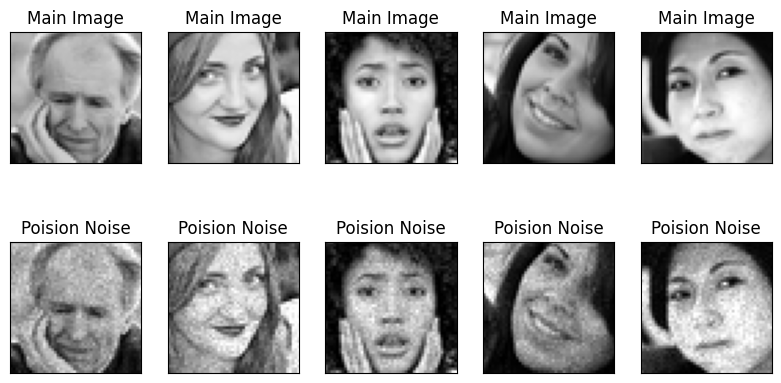

In [9]:
import matplotlib.pyplot as plt

np.random.seed(48)

indices = np.random.randint(0, y_test.shape[0], size=5)

fig = plt.figure(figsize=(20, 5))

for i, index in enumerate(indices):
  plt.subplot(2, 10, i + 1, xticks=[], yticks=[])
  plt.imshow(y_test[index], cmap=plt.cm.binary_r), plt.title('Main Image')
for i, index in enumerate(indices):
  plt.subplot(2, 10, i + 11, xticks=[], yticks=[])
  plt.imshow(x_test[index], cmap=plt.cm.binary_r), plt.title('Poision Noise')

plt.show()

In [10]:
x_train = x_train / 255.0
x_valid = x_valid / 255.0
x_test = x_test / 255.0
y_train = y_train / 255.0
y_valid = y_valid / 255.0
y_test = y_test / 255.0

In [20]:
def build_generator(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    encoder1 = layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu")(inputs)
    encoder2 = layers.Conv2D(128, kernel_size=3, strides=2, padding="same", activation="relu")(encoder1)
    encoder3 = layers.Conv2D(256, kernel_size=3, strides=2, padding="same", activation="relu")(encoder2)

    # Bottleneck
    bottleneck = layers.Conv2D(512, kernel_size=3, padding="same", activation="relu")(encoder3)

    # Decoder
    decoder1 = layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding="same", activation="relu")(bottleneck)
    decoder2 = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same", activation="relu")(decoder1)
    decoder3 = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu")(decoder2)

    # Output layer
    outputs = layers.Conv2D(1, kernel_size=3, activation="sigmoid", padding="same")(decoder3)

    return models.Model(inputs, outputs, name="Generator")


# Discriminator Model
def build_discriminator(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(128, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation="sigmoid")(x)

    return models.Model(inputs, x, name="Discriminator")



In [ ]:
input_shape = (48, 48, 1)
generator = build_generator(input_shape)
discriminator = build_discriminator(input_shape)


In [ ]:
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                      loss="binary_crossentropy",
                      metrics=["accuracy"])


In [ ]:
discriminator.trainable = False
gan_input = tf.keras.Input(shape=input_shape)
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)

In [ ]:
gan_model = models.Model(gan_input, gan_output, name="GAN")
gan_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                  loss="binary_crossentropy")

In [ ]:
def preprocess_images(image_paths, size=(48, 48)):
    images = []
    for path in image_paths:
        img = Image.open(path).convert("L")
        img = img.resize(size)
        images.append(np.array(img, dtype=np.float32) / 255.0)
    images = np.expand_dims(images, axis=-1)
    return np.array(images)


In [ ]:
clean_image_dir = "path_to_clean_images"
noisy_image_dir = "path_to_noisy_images"


In [ ]:
clean_images = preprocess_images([os.path.join(clean_image_dir, f) for f in os.listdir(clean_image_dir)])
noisy_images = preprocess_images([os.path.join(noisy_image_dir, f) for f in os.listdir(noisy_image_dir)])

In [ ]:
epochs = 50
batch_size = 32
steps_per_epoch = len(clean_images) // batch_size

# Training Loop
for epoch in range(epochs):
    for step in range(steps_per_epoch):
        # Sample real and noisy images
        idx = np.random.randint(0, clean_images.shape[0], batch_size)
        real_images = clean_images[idx]
        noise_images = noisy_images[idx]

        # Generate fake images
        fake_images = generator.predict(noise_images)

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(real_images, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((batch_size, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        g_loss = gan_model.train_on_batch(noise_images, np.ones((batch_size, 1)))

    print(f"Epoch {epoch+1}/{epochs}, D Loss: {d_loss[0]:.4f}, D Accuracy: {d_loss[1]:.4f}, G Loss: {g_loss:.4f}")

# Save Models
generator.save("generator_model.h5")
discriminator.save("discriminator_model.h5")

In [ ]:
test_image_path = "path_to_test_image"
test_image = preprocess_images([test_image_path])
denoised_image = generator.predict(test_image)

# Visualize Results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(test_image[0, :, :, 0], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("Noisy Image")
plt.imshow(noisy_images[0, :, :, 0], cmap="gray")
plt.subplot(1, 3, 3)
plt.title("Denoised Image")
plt.imshow(denoised_image[0, :, :, 0], cmap="gray")
plt.show()